In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

FILEMAP = {
    'BTC' : r'../resources/data/raw/BTC_USDT_1m.csv',
    'ADA' : r'../resources/data/raw/ADA_USDT_1m.csv',
    'ALGO' : r'../resources/data/raw/ALGO_USDT_1m.csv',
    'ANKR': r'../resources/data/raw/ANKR_USDT_1m.csv',
}

COL_PRICE    = 'close'      # ценовата колона в CSV-то
TIMEZONE     = 'UTC'        # всички в UTC
RISK_FREE    = 0.00         # годишен r_f; 0.0 ако не ти трябва
WEIGHT_CAP   = 0.50         # ≤ 50 % в един актив
N_PORTFOLIOS = 25_000       # Монте Карло проби
SEED         = 42
TEST_FRAC = 0.20          # 20 % test
np.random.seed(SEED)

# --- 1-минутни барове → 525 600 на година ----------------------------
BAR_SEC           = 60
PERIODS_PER_YEAR  = int(365 * 86_400 / BAR_SEC) 
print(f'periods_per_year = {PERIODS_PER_YEAR:,}')

periods_per_year = 525,600


In [2]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 1) Зареждане на минутните цени                              ║
# ╚═════════════════════════════════════════════════════════════╝
def load_iso_csv(path: str | Path,
                 price_col: str = COL_PRICE,
                 tz: str = TIMEZONE) -> pd.Series:
    """
    Чете CSV с ISO `timestamp` и връща Series<price> (tz-aware).
    """
    df = pd.read_csv(path,
                     parse_dates=['timestamp'],
                     index_col='timestamp')
    df.index = df.index.tz_localize(tz)
    return df[price_col].astype(float)


# --- комбинираме всички активи ----------------------------------------
prices = pd.concat(
    {tkr: load_iso_csv(p) for tkr, p in FILEMAP.items()},
    axis=1, join='inner').sort_index()

# 2) намираме cut-off timestamp
cut_idx   = int(len(prices) * (1 - TEST_FRAC))
cut_date  = prices.index[cut_idx]          # tz-aware
print(f'🔪 Cut date (80/20 split) → {cut_date}')

# 3) правим две отделни рамки
train_prices = prices.loc[:cut_date]
test_prices  = prices.loc[cut_date + pd.Timedelta(minutes=1):]   # +1 мин. за да не дублираме

assert train_prices.index.max() < test_prices.index.min()
print(train_prices.shape, test_prices.shape)

🔪 Cut date (80/20 split) → 2024-03-27 12:29:00+00:00
(420492, 4) (105122, 4)


In [3]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 2) Минутни доходности, μ̅, Σ                                ║
# ╚═════════════════════════════════════════════════════════════╝
train_rets = train_prices.pct_change().dropna()

# проверка, че са 1-минутни
freq = train_rets.index.to_series().diff().dt.total_seconds().median()
assert freq == BAR_SEC, f'Открих {freq=} сек. – не е 1-мин серия!'

means_bar = train_rets.mean().values                  # μ_i  (за 1 бар)
cov_bar   = train_rets.cov().values                  # Σ    (за 1 бар)
tickers   = list(FILEMAP.keys())

# кратка статистика
stats = pd.DataFrame({'μ_bar': means_bar,
                      'σ_bar': train_rets.std(ddof=0).values},
                     index=tickers)
stats['Sharpe_bar'] = stats['μ_bar'] / stats['σ_bar']
display(stats)


,μ_bar,σ_bar,Sharpe_bar
BTC,0.000003,0.000642,0.003908
ADA,0.000002,0.001134,0.002089
ALGO,0.000003,0.001320,0.002133
ANKR,0.000003,0.001390,0.002297


In [4]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 3) Монте-Карло портфейли (с ограничение на теглото)         ║
# ╚═════════════════════════════════════════════════════════════╝
n_assets = len(tickers)
results  = np.zeros((3, N_PORTFOLIOS))          # σ, μ, Sharpe
weights  = np.zeros((N_PORTFOLIOS, n_assets))

i = 0
while i < N_PORTFOLIOS:
    w = np.random.random(n_assets)
    w /= w.sum()
    if (w > WEIGHT_CAP).any():          # концентрационен лимит
        continue

    mu_bar  = np.dot(w, means_bar)
    sig_bar = np.sqrt(w @ cov_bar @ w)

    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    weights[i]   = w
    results[0,i] = sig_ann
    results[1,i] = mu_ann
    results[2,i] = (mu_ann - RISK_FREE) / sig_ann

    i += 1

idx_max_sharpe = results[2].argmax()
idx_min_vol    = results[0].argmin()


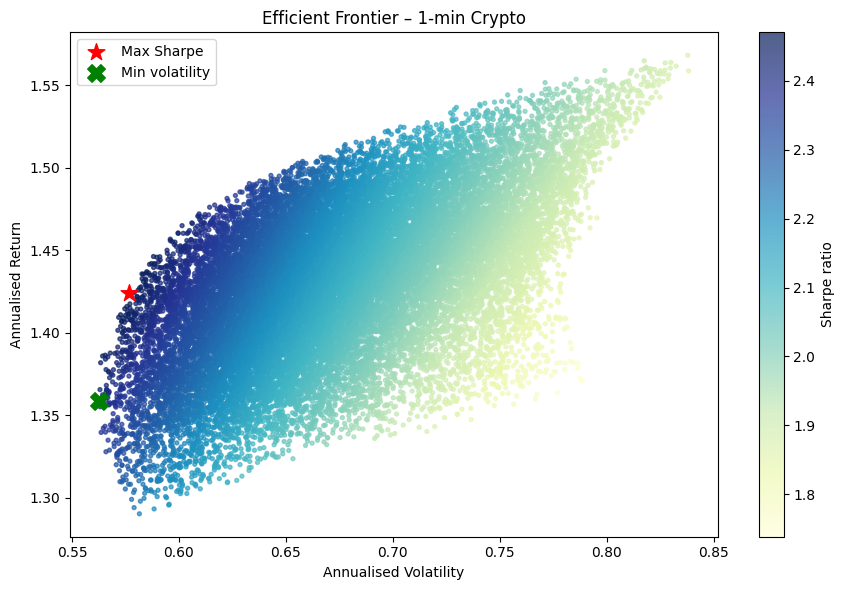

In [5]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 4) Графика: Efficient Frontier                             ║
# ╚═════════════════════════════════════════════════════════════╝
fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(results[0], results[1],
                c=results[2], cmap='YlGnBu', s=8, alpha=0.7)
fig.colorbar(sc, label='Sharpe ratio')

ax.scatter(*results[:2, idx_max_sharpe],
           marker='*', s=160, color='r', label='Max Sharpe')
ax.scatter(*results[:2, idx_min_vol],
           marker='X', s=160, color='g', label='Min volatility')

ax.set(title='Efficient Frontier – 1-min Crypto',
       xlabel='Annualised Volatility',
       ylabel='Annualised Return')
ax.legend(); plt.tight_layout()


In [6]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 5) Показване на разпределенията                             ║
# ╚═════════════════════════════════════════════════════════════╝
alloc_max = pd.Series(weights[idx_max_sharpe], index=tickers).round(2)
alloc_min = pd.Series(weights[idx_min_vol   ], index=tickers).round(2)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МАКС. SHARPE')
print(f"  Год. доходност : {results[1, idx_max_sharpe]:.2%}")
print(f"  Год. волатилност : {results[0, idx_max_sharpe]:.2%}\n")
display(alloc_max.to_frame('Weight').T)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ')
print(f"  Год. доходност : {results[1, idx_min_vol]:.2%}")
print(f"  Год. волатилност : {results[0, idx_min_vol]:.2%}\n")
display(alloc_min.to_frame('Weight').T)



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МАКС. SHARPE
  Год. доходност : 142.41%
  Год. волатилност : 57.65%



,BTC,ADA,ALGO,ANKR
Weight,0.5,0.1,0.15,0.24



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
  Год. доходност : 135.85%
  Год. волатилност : 56.28%



,BTC,ADA,ALGO,ANKR
Weight,0.5,0.26,0.14,0.1


In [7]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 6) Генетичен алгоритъм – оптимизация на Sharpe              ║
# ╚═════════════════════════════════════════════════════════════╝
import random

# --------------------------------------------------------------
# Хиперпараметри на GA
# --------------------------------------------------------------
POP_SIZE       = 1000          # колко индивида във всяко поколение
NB_GENERATIONS = 50             # колко поколения
ELITE_FRAC     = 0.10           # най-добрият % индивиди, които копираме директно
MUTATE_FRAC    = 0.15           # шанс дадено дете да бъде мутант
MUTATE_SCALE   = 0.10           # колко силно „рита“ мутантът теглото
PLOT_X = 5
PLOT_Y = 5


np.random.seed(123)

# --------------------------------------------------------------
# Фитнес функция – годишен Sharpe
# --------------------------------------------------------------
def fitness(w: np.ndarray) -> float:
    """
    w трябва вече да е нормализиран: Σ w_i = 1
    """
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    return (mu_ann - RISK_FREE) / sig_ann


# --------------------------------------------------------------
# GA инструменти: кросоувър, мутация, създаване на поколение
# --------------------------------------------------------------
def crossover(p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Симпъл α-crossover (α ~ U[0,1])
    """
    α = np.random.rand()
    c1 = α * p1 + (1 - α) * p2
    c2 = (1 - α) * p1 + α * p2
    return c1, c2

def mutate(child: np.ndarray) -> np.ndarray:
    """
    Избутва случайно тегло с N(0, MUTATE_SCALE).
    После нормализира и реже до WEIGHT_CAP.
    """
    idx = np.random.randint(len(child))
    child[idx] += np.random.normal(0, MUTATE_SCALE)
    child = np.clip(child, 0, WEIGHT_CAP)      # защитно изрязване
    child /= child.sum()
    return child

def next_generation(pop: list[np.ndarray]) -> list[np.ndarray]:
    """
    Създава следващото поколение:
      1. сортира по fitness (низходящ)
      2. взема ELITE_FRAC като “елит”
      3. прави деца чрез кросоувър
      4. мутира част от децата
      5. нормализира теглата
    """
    pop = sorted(pop, key=fitness, reverse=True)
    elite_n = int(len(pop) * ELITE_FRAC)
    new_pop = pop[:elite_n]                       # запазваме елита
    
    # ––– рандомизираме елита, за да правим случайни двойки
    random.shuffle(new_pop)
    parents = new_pop.copy()
    
    # ––– кросоувър
    children = []
    for p1, p2 in zip(parents[::2], parents[1::2]):
        c1, c2 = crossover(p1, p2)
        children.extend([c1, c2])
    
    # ––– мутации
    for k in range(len(children)):
        if np.random.rand() < MUTATE_FRAC:
            children[k] = mutate(children[k])
        # задължителна нормализация + cap
        children[k] = np.clip(children[k], 0, WEIGHT_CAP)
        children[k] /= children[k].sum()
    
    new_pop.extend(children)
    
    # ако популацията е недостатъчна (нечетен брой родители)
    while len(new_pop) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        new_pop.append(w)
    return new_pop[:POP_SIZE]


# hyperparameters optimizer
import numpy as np, random, math, optuna, time
from copy import deepcopy
def run_ga_once(pop_size, nb_generations, elite_frac,
                mutate_frac, mutate_scale,
                weight_cap, seed=None):
    """
    Стартира ЕДНО изпълнение на GA с подадените хиперпараметри.
    Връща Sharpe на най-добрия индивид.
    """

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # -------------- локални override-и на глобалните константи --------------
    global POP_SIZE, NB_GENERATIONS, ELITE_FRAC
    global MUTATE_FRAC, MUTATE_SCALE, WEIGHT_CAP

    POP_SIZE       = pop_size
    NB_GENERATIONS = nb_generations
    ELITE_FRAC     = elite_frac
    MUTATE_FRAC    = mutate_frac
    MUTATE_SCALE   = mutate_scale
    WEIGHT_CAP     = weight_cap          # нов параметър!

    # -------------- инициализираме първото поколение ------------------------
    population = []
    while len(population) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        population.append(w)

    # -------------- еволюираме ----------------------------------------------
    best_fit = -math.inf
    for g in range(NB_GENERATIONS):
        population = next_generation(population)
        # оценяваме елита
        top = max(population, key=fitness)
        best_fit = max(best_fit, fitness(top))

    return best_fit   # ↑ Sharpe на най-силния индивид

def objective(trial: optuna.trial.Trial) -> float:
    """
    Optuna ще пробва различни GA-хиперпараметри и ще
    връща >>средния<< Sharpe от K рестарта на GA.
    """
    # 1) дефинираме търсено пространство
    pop_size       = trial.suggest_int   ('pop_size',        200, 1500, step=100)
    nb_generations = trial.suggest_int   ('nb_generations',   20, 200,  step=10)
    elite_frac     = trial.suggest_float ('elite_frac',      0.05, 0.35)
    mutate_frac    = trial.suggest_float ('mutate_frac',     0.05, 0.40)
    mutate_scale   = trial.suggest_float ('mutate_scale',    0.01, 0.50, log=True)
    weight_cap     = trial.suggest_float ('weight_cap',      0.30, 0.70)

    # 2) за стабилност ‒ стартираме GA K пъти с разл. seed
    K, scores = 3, []
    for k in range(K):
        seed = 2024 + k
        score = run_ga_once(pop_size, nb_generations,
                            elite_frac, mutate_frac, mutate_scale,
                            weight_cap, seed=seed)
        scores.append(score)

    # 3) Optuna максимизира -> връщаме средната стойност
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner =optuna.pruners.MedianPruner(
                                        n_startup_trials=10, n_warmup_steps=5))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
study.optimize(objective,
               n_trials = 40,          # или по време: timeout=3600
               show_progress_bar=True)

print("🏆 Най-добрите GA-хиперпараметри:")
for k, v in study.best_trial.params.items():
    print(f"  {k:15s} : {v}")
print("Среден Sharpe  :", study.best_value)




/home/npenchev/fun/summer-school-2025-crypto-forecasting/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-28 20:56:55,381] A new study created in memory with name: no-name-aec71ac0-3815-4c6e-a257-41d4058a07e9
Best trial: 0. Best value: 2.58929:   2%|█                                           | 1/40 [00:23<15:29, 23.82s/it]

[I 2025-06-28 20:57:19,200] Trial 0 finished with value: 2.5892935785289852 and parameters: {'pop_size': 1500, 'nb_generations': 170, 'elite_frac': 0.19957317780704864, 'mutate_frac': 0.31381235385022604, 'mutate_scale': 0.040746928585541534, 'weight_cap': 0.5381294913922441}. Best is trial 0 with value: 2.5892935785289852.


Best trial: 0. Best value: 2.58929:   5%|██▏                                         | 2/40 [00:43<13:34, 21.42s/it]

[I 2025-06-28 20:57:38,948] Trial 1 finished with value: 2.269679067117502 and parameters: {'pop_size': 500, 'nb_generations': 160, 'elite_frac': 0.284165983549188, 'mutate_frac': 0.1641893141231936, 'mutate_scale': 0.027670191840801505, 'weight_cap': 0.3137106635013148}. Best is trial 0 with value: 2.5892935785289852.


Best trial: 0. Best value: 2.58929:   8%|███▎                                        | 3/40 [00:47<08:18, 13.48s/it]

[I 2025-06-28 20:57:42,967] Trial 2 finished with value: 2.386728351183242 and parameters: {'pop_size': 500, 'nb_generations': 60, 'elite_frac': 0.08063436467035509, 'mutate_frac': 0.39815333804144115, 'mutate_scale': 0.040411322567994894, 'weight_cap': 0.41179716576564696}. Best is trial 0 with value: 2.5892935785289852.


Best trial: 3. Best value: 2.8399:  10%|████▌                                        | 4/40 [01:04<08:54, 14.84s/it]

[I 2025-06-28 20:57:59,910] Trial 3 finished with value: 2.839904890237618 and parameters: {'pop_size': 900, 'nb_generations': 190, 'elite_frac': 0.2660244146694913, 'mutate_frac': 0.2810605343176408, 'mutate_scale': 0.4166748210511261, 'weight_cap': 0.4547473381480995}. Best is trial 3 with value: 2.839904890237618.


Best trial: 3. Best value: 2.8399:  12%|█████▋                                       | 5/40 [01:08<06:24, 10.99s/it]

[I 2025-06-28 20:58:04,065] Trial 4 finished with value: 2.4389171261757436 and parameters: {'pop_size': 300, 'nb_generations': 130, 'elite_frac': 0.052904773825739895, 'mutate_frac': 0.23203071353575255, 'mutate_scale': 0.08165580827527627, 'weight_cap': 0.43516423049617436}. Best is trial 3 with value: 2.839904890237618.


Best trial: 3. Best value: 2.8399:  15%|██████▊                                      | 6/40 [01:14<05:10,  9.12s/it]

[I 2025-06-28 20:58:09,563] Trial 5 finished with value: 2.508083078037614 and parameters: {'pop_size': 800, 'nb_generations': 70, 'elite_frac': 0.051622917512039616, 'mutate_frac': 0.2521836127082312, 'mutate_scale': 0.08663202458556078, 'weight_cap': 0.4771356434914851}. Best is trial 3 with value: 2.839904890237618.


Best trial: 3. Best value: 2.8399:  18%|███████▊                                     | 7/40 [01:16<03:52,  7.03s/it]

[I 2025-06-28 20:58:12,288] Trial 6 finished with value: 2.5915780162185587 and parameters: {'pop_size': 200, 'nb_generations': 140, 'elite_frac': 0.08860558553666639, 'mutate_frac': 0.3505429456596105, 'mutate_scale': 0.017999886019965897, 'weight_cap': 0.5757669053844647}. Best is trial 3 with value: 2.839904890237618.


Best trial: 3. Best value: 2.8399:  20%|█████████                                    | 8/40 [01:36<05:54, 11.07s/it]

[I 2025-06-28 20:58:32,016] Trial 7 finished with value: 2.801008805755877 and parameters: {'pop_size': 1300, 'nb_generations': 160, 'elite_frac': 0.1395595338914371, 'mutate_frac': 0.11099952570228658, 'mutate_scale': 0.16754409699363715, 'weight_cap': 0.5630667524555584}. Best is trial 3 with value: 2.839904890237618.


Best trial: 3. Best value: 2.8399:  22%|██████████▏                                  | 9/40 [02:18<10:41, 20.68s/it]

[I 2025-06-28 20:59:13,819] Trial 8 finished with value: 2.7943014995811857 and parameters: {'pop_size': 1000, 'nb_generations': 190, 'elite_frac': 0.2105812612533709, 'mutate_frac': 0.3653748868598735, 'mutate_scale': 0.3351775551633591, 'weight_cap': 0.3272648039787575}. Best is trial 3 with value: 2.839904890237618.


Best trial: 9. Best value: 2.8423:  25%|███████████                                 | 10/40 [02:21<07:40, 15.35s/it]

[I 2025-06-28 20:59:17,223] Trial 9 finished with value: 2.8423047162203647 and parameters: {'pop_size': 300, 'nb_generations': 110, 'elite_frac': 0.3434546780038247, 'mutate_frac': 0.05804327449345514, 'mutate_scale': 0.17016165432411834, 'weight_cap': 0.6929602364980757}. Best is trial 9 with value: 2.8423047162203647.


Best trial: 10. Best value: 2.84779:  28%|███████████▌                              | 11/40 [02:27<06:00, 12.43s/it]

[I 2025-06-28 20:59:23,053] Trial 10 finished with value: 2.847788742596079 and parameters: {'pop_size': 600, 'nb_generations': 100, 'elite_frac': 0.3356683043954244, 'mutate_frac': 0.051041317599248126, 'mutate_scale': 0.17706520402548917, 'weight_cap': 0.6992221868211206}. Best is trial 10 with value: 2.847788742596079.


Best trial: 10. Best value: 2.84779:  30%|████████████▌                             | 12/40 [02:32<04:44, 10.17s/it]

[I 2025-06-28 20:59:28,031] Trial 11 finished with value: 2.8443504186770228 and parameters: {'pop_size': 600, 'nb_generations': 90, 'elite_frac': 0.3446414042836494, 'mutate_frac': 0.050675549805247584, 'mutate_scale': 0.17747720822620355, 'weight_cap': 0.6963261254766134}. Best is trial 10 with value: 2.847788742596079.


Best trial: 10. Best value: 2.84779:  32%|█████████████▋                            | 13/40 [02:34<03:26,  7.64s/it]

[I 2025-06-28 20:59:29,846] Trial 12 finished with value: 2.789419272299772 and parameters: {'pop_size': 600, 'nb_generations': 30, 'elite_frac': 0.3371490432546829, 'mutate_frac': 0.05574321423249664, 'mutate_scale': 0.19147146997737194, 'weight_cap': 0.6860547582911646}. Best is trial 10 with value: 2.847788742596079.


Best trial: 13. Best value: 2.84884:  35%|██████████████▋                           | 14/40 [02:40<03:06,  7.17s/it]

[I 2025-06-28 20:59:35,939] Trial 13 finished with value: 2.8488446816322566 and parameters: {'pop_size': 700, 'nb_generations': 90, 'elite_frac': 0.2940256274232891, 'mutate_frac': 0.1603138442575941, 'mutate_scale': 0.2542703280166904, 'weight_cap': 0.6277763111605701}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  38%|███████████████▊                          | 15/40 [02:50<03:20,  8.02s/it]

[I 2025-06-28 20:59:45,940] Trial 14 finished with value: 2.6607768419982865 and parameters: {'pop_size': 1100, 'nb_generations': 100, 'elite_frac': 0.2879506875897903, 'mutate_frac': 0.170796686232087, 'mutate_scale': 0.010045950515123551, 'weight_cap': 0.6398810558999404}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  40%|████████████████▊                         | 16/40 [02:55<02:50,  7.10s/it]

[I 2025-06-28 20:59:50,893] Trial 15 finished with value: 2.8431709407282693 and parameters: {'pop_size': 800, 'nb_generations': 70, 'elite_frac': 0.2361906309708835, 'mutate_frac': 0.16794844339418602, 'mutate_scale': 0.2820871686434596, 'weight_cap': 0.6249836441233199}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  42%|█████████████████▊                        | 17/40 [02:56<02:02,  5.35s/it]

[I 2025-06-28 20:59:52,160] Trial 16 finished with value: 2.77821529876647 and parameters: {'pop_size': 700, 'nb_generations': 20, 'elite_frac': 0.3130197336015509, 'mutate_frac': 0.11784687971697826, 'mutate_scale': 0.49820047146909063, 'weight_cap': 0.6234776753481766}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  45%|██████████████████▉                       | 18/40 [03:10<02:54,  7.92s/it]

[I 2025-06-28 21:00:06,084] Trial 17 finished with value: 2.7008157418355014 and parameters: {'pop_size': 1200, 'nb_generations': 130, 'elite_frac': 0.2489283241642988, 'mutate_frac': 0.11316079626788367, 'mutate_scale': 0.11825266416434721, 'weight_cap': 0.5236367716512048}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  48%|███████████████████▉                      | 19/40 [03:12<02:07,  6.07s/it]

[I 2025-06-28 21:00:07,836] Trial 18 finished with value: 2.844217723532129 and parameters: {'pop_size': 400, 'nb_generations': 50, 'elite_frac': 0.309804767815729, 'mutate_frac': 0.18319761098706253, 'mutate_scale': 0.24864976799067032, 'weight_cap': 0.6482458779853443}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 13. Best value: 2.84884:  50%|█████████████████████                     | 20/40 [03:19<02:09,  6.48s/it]

[I 2025-06-28 21:00:15,277] Trial 19 finished with value: 2.7447820331198645 and parameters: {'pop_size': 900, 'nb_generations': 90, 'elite_frac': 0.17079820989867095, 'mutate_frac': 0.09048663219978709, 'mutate_scale': 0.10244296080132874, 'weight_cap': 0.5929462354966764}. Best is trial 13 with value: 2.8488446816322566.


Best trial: 20. Best value: 2.85627:  52%|██████████████████████                    | 21/40 [03:27<02:09,  6.83s/it]

[I 2025-06-28 21:00:22,920] Trial 20 finished with value: 2.856268459551263 and parameters: {'pop_size': 700, 'nb_generations': 110, 'elite_frac': 0.3086599362213034, 'mutate_frac': 0.19309455449977375, 'mutate_scale': 0.13945257170612615, 'weight_cap': 0.6652542330622687}. Best is trial 20 with value: 2.856268459551263.


Best trial: 20. Best value: 2.85627:  55%|███████████████████████                   | 22/40 [03:35<02:07,  7.08s/it]

[I 2025-06-28 21:00:30,587] Trial 21 finished with value: 2.8215562790831616 and parameters: {'pop_size': 700, 'nb_generations': 110, 'elite_frac': 0.3079062270664903, 'mutate_frac': 0.19767574465187016, 'mutate_scale': 0.05960738248332782, 'weight_cap': 0.6598851961349466}. Best is trial 20 with value: 2.856268459551263.


Best trial: 20. Best value: 2.85627:  57%|████████████████████████▏                 | 23/40 [03:40<01:51,  6.58s/it]

[I 2025-06-28 21:00:35,989] Trial 22 finished with value: 2.8156326445218283 and parameters: {'pop_size': 700, 'nb_generations': 80, 'elite_frac': 0.28163648730545293, 'mutate_frac': 0.13780954895346065, 'mutate_scale': 0.12953905410273003, 'weight_cap': 0.6102655918344463}. Best is trial 20 with value: 2.856268459551263.


Best trial: 23. Best value: 2.85698:  60%|█████████████████████████▏                | 24/40 [03:46<01:41,  6.35s/it]

[I 2025-06-28 21:00:41,815] Trial 23 finished with value: 2.8569830256895017 and parameters: {'pop_size': 500, 'nb_generations': 120, 'elite_frac': 0.3213162767766616, 'mutate_frac': 0.2562990679547653, 'mutate_scale': 0.24917251919780933, 'weight_cap': 0.6604895015646645}. Best is trial 23 with value: 2.8569830256895017.


Best trial: 23. Best value: 2.85698:  62%|██████████████████████████▎               | 25/40 [03:51<01:27,  5.86s/it]

[I 2025-06-28 21:00:46,526] Trial 24 finished with value: 2.8560598480661334 and parameters: {'pop_size': 400, 'nb_generations': 130, 'elite_frac': 0.24558694689103416, 'mutate_frac': 0.21458716007359435, 'mutate_scale': 0.2488396723898718, 'weight_cap': 0.6666135147071292}. Best is trial 23 with value: 2.8569830256895017.


Best trial: 25. Best value: 2.85708:  65%|███████████████████████████▎              | 26/40 [03:56<01:18,  5.63s/it]

[I 2025-06-28 21:00:51,632] Trial 25 finished with value: 2.8570804722144665 and parameters: {'pop_size': 400, 'nb_generations': 140, 'elite_frac': 0.24022817486384052, 'mutate_frac': 0.21885991508608582, 'mutate_scale': 0.3295354192760529, 'weight_cap': 0.6634478057004165}. Best is trial 25 with value: 2.8570804722144665.


Best trial: 25. Best value: 2.85708:  68%|████████████████████████████▎             | 27/40 [03:59<01:02,  4.83s/it]

[I 2025-06-28 21:00:54,573] Trial 26 finished with value: 2.8550934787649855 and parameters: {'pop_size': 200, 'nb_generations': 150, 'elite_frac': 0.21366641384206914, 'mutate_frac': 0.26031656167239625, 'mutate_scale': 0.3911567123281225, 'weight_cap': 0.5575093334394354}. Best is trial 25 with value: 2.8570804722144665.


Best trial: 25. Best value: 2.85708:  70%|█████████████████████████████▍            | 28/40 [04:03<00:56,  4.74s/it]

[I 2025-06-28 21:00:59,119] Trial 27 finished with value: 2.854626277712223 and parameters: {'pop_size': 400, 'nb_generations': 120, 'elite_frac': 0.26276521405547854, 'mutate_frac': 0.2945733401210214, 'mutate_scale': 0.3287801615238833, 'weight_cap': 0.6040006235226657}. Best is trial 25 with value: 2.8570804722144665.


Best trial: 25. Best value: 2.85708:  72%|██████████████████████████████▍           | 29/40 [04:14<01:11,  6.47s/it]

[I 2025-06-28 21:01:09,609] Trial 28 finished with value: 2.3482702187080737 and parameters: {'pop_size': 500, 'nb_generations': 170, 'elite_frac': 0.1709666050878308, 'mutate_frac': 0.23232834365384583, 'mutate_scale': 0.05813231420383022, 'weight_cap': 0.37802908068007346}. Best is trial 25 with value: 2.8570804722144665.


Best trial: 29. Best value: 2.85709:  75%|███████████████████████████████▌          | 30/40 [04:37<01:53, 11.37s/it]

[I 2025-06-28 21:01:32,426] Trial 29 finished with value: 2.8570914849488696 and parameters: {'pop_size': 1500, 'nb_generations': 170, 'elite_frac': 0.22582753433952746, 'mutate_frac': 0.30457325012526737, 'mutate_scale': 0.49632835925932833, 'weight_cap': 0.6646250337013249}. Best is trial 29 with value: 2.8570914849488696.


Best trial: 29. Best value: 2.85709:  78%|████████████████████████████████▌         | 31/40 [05:05<02:29, 16.57s/it]

[I 2025-06-28 21:02:01,113] Trial 30 finished with value: 2.8568646280734047 and parameters: {'pop_size': 1500, 'nb_generations': 200, 'elite_frac': 0.17171276098916588, 'mutate_frac': 0.30822744579049716, 'mutate_scale': 0.49360998508599313, 'weight_cap': 0.5063845342139228}. Best is trial 29 with value: 2.8570914849488696.


Best trial: 31. Best value: 2.85728:  80%|█████████████████████████████████▌        | 32/40 [05:33<02:39, 19.91s/it]

[I 2025-06-28 21:02:28,841] Trial 31 finished with value: 2.857277900452308 and parameters: {'pop_size': 1500, 'nb_generations': 200, 'elite_frac': 0.18179293191111695, 'mutate_frac': 0.32473025181595083, 'mutate_scale': 0.49655895372991077, 'weight_cap': 0.5211172705528623}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  82%|██████████████████████████████████▋       | 33/40 [05:56<02:26, 20.94s/it]

[I 2025-06-28 21:02:52,189] Trial 32 finished with value: 2.8557266510546486 and parameters: {'pop_size': 1400, 'nb_generations': 180, 'elite_frac': 0.13374047537490164, 'mutate_frac': 0.32972251286416426, 'mutate_scale': 0.37203666904640503, 'weight_cap': 0.5388748220864746}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  85%|███████████████████████████████████▋      | 34/40 [06:18<02:07, 21.30s/it]

[I 2025-06-28 21:03:14,323] Trial 33 finished with value: 2.856566379254602 and parameters: {'pop_size': 1400, 'nb_generations': 170, 'elite_frac': 0.19802672431473567, 'mutate_frac': 0.27185521030331, 'mutate_scale': 0.29993182778831007, 'weight_cap': 0.5869638998177685}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  88%|████████████████████████████████████▊     | 35/40 [06:43<01:50, 22.14s/it]

[I 2025-06-28 21:03:38,407] Trial 34 finished with value: 2.732896592792264 and parameters: {'pop_size': 1400, 'nb_generations': 150, 'elite_frac': 0.22612583340464845, 'mutate_frac': 0.3414862331818267, 'mutate_scale': 0.474383124584118, 'weight_cap': 0.38297191365100147}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  90%|█████████████████████████████████████▊    | 36/40 [07:11<01:36, 24.11s/it]

[I 2025-06-28 21:04:07,139] Trial 35 finished with value: 2.8561923935801556 and parameters: {'pop_size': 1500, 'nb_generations': 200, 'elite_frac': 0.19013580852295425, 'mutate_frac': 0.3956245705993122, 'mutate_scale': 0.2173435336278824, 'weight_cap': 0.47942759333576535}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  92%|██████████████████████████████████████▊   | 37/40 [07:31<01:08, 22.67s/it]

[I 2025-06-28 21:04:26,436] Trial 36 finished with value: 2.8565731319580507 and parameters: {'pop_size': 1200, 'nb_generations': 180, 'elite_frac': 0.143294706531515, 'mutate_frac': 0.3127342633232082, 'mutate_scale': 0.40496455886367755, 'weight_cap': 0.6702754362170977}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  95%|███████████████████████████████████████▉  | 38/40 [07:50<00:43, 21.68s/it]

[I 2025-06-28 21:04:45,798] Trial 37 finished with value: 2.7844030667637756 and parameters: {'pop_size': 1300, 'nb_generations': 150, 'elite_frac': 0.11378233696883494, 'mutate_frac': 0.24587100951293805, 'mutate_scale': 0.3411696591340724, 'weight_cap': 0.4406774748537165}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728:  98%|████████████████████████████████████████▉ | 39/40 [07:54<00:16, 16.52s/it]

[I 2025-06-28 21:04:50,290] Trial 38 finished with value: 2.854285878278667 and parameters: {'pop_size': 300, 'nb_generations': 160, 'elite_frac': 0.26482461923812384, 'mutate_frac': 0.28319545903522636, 'mutate_scale': 0.415536350325333, 'weight_cap': 0.6438020928983498}. Best is trial 31 with value: 2.857277900452308.


Best trial: 31. Best value: 2.85728: 100%|██████████████████████████████████████████| 40/40 [08:11<00:00, 12.28s/it]

[I 2025-06-28 21:05:06,626] Trial 39 finished with value: 2.8552479766969907 and parameters: {'pop_size': 1000, 'nb_generations': 180, 'elite_frac': 0.1849285249229861, 'mutate_frac': 0.21712649081605506, 'mutate_scale': 0.21589079448996115, 'weight_cap': 0.5783266276471728}. Best is trial 31 with value: 2.857277900452308.
🏆 Най-добрите GA-хиперпараметри:
  pop_size        : 1500
  nb_generations  : 200
  elite_frac      : 0.18179293191111695
  mutate_frac     : 0.32473025181595083
  mutate_scale    : 0.49655895372991077
  weight_cap      : 0.5211172705528623
Среден Sharpe  : 2.857277900452308


In [8]:
    # POP_SIZE       = pop_size
    # NB_GENERATIONS = nb_generations
    # ELITE_FRAC     = elite_frac
    # MUTATE_FRAC    = mutate_frac
    # MUTATE_SCALE   = mutate_scale
    # WEIGHT_CAP     = weight_cap 
print("OPTIMIZED HYPERPARAMETERS")
print(f"POP_SIZE: {POP_SIZE}")
print(f"NB_GENERATIONS: {NB_GENERATIONS}")
print(f"ELITE_FRAC: {ELITE_FRAC}")
print(f"MUTATE_FRAC: {MUTATE_FRAC}")
print(f"MUTATE_SCALE: {MUTATE_SCALE}")
print(f"WEIGHT_CAP: {WEIGHT_CAP}")

OPTIMIZED HYPERPARAMETERS
POP_SIZE: 1000
NB_GENERATIONS: 180
ELITE_FRAC: 0.1849285249229861
MUTATE_FRAC: 0.21712649081605506
MUTATE_SCALE: 0.21589079448996115
WEIGHT_CAP: 0.5783266276471728


Ще се визуализират поколения: [0, 7, 14, 22, 29, 37, 44, 52, 59, 67, 74, 82, 89, 96, 104, 111, 119, 126, 134, 141, 149, 156, 164, 171, 179]


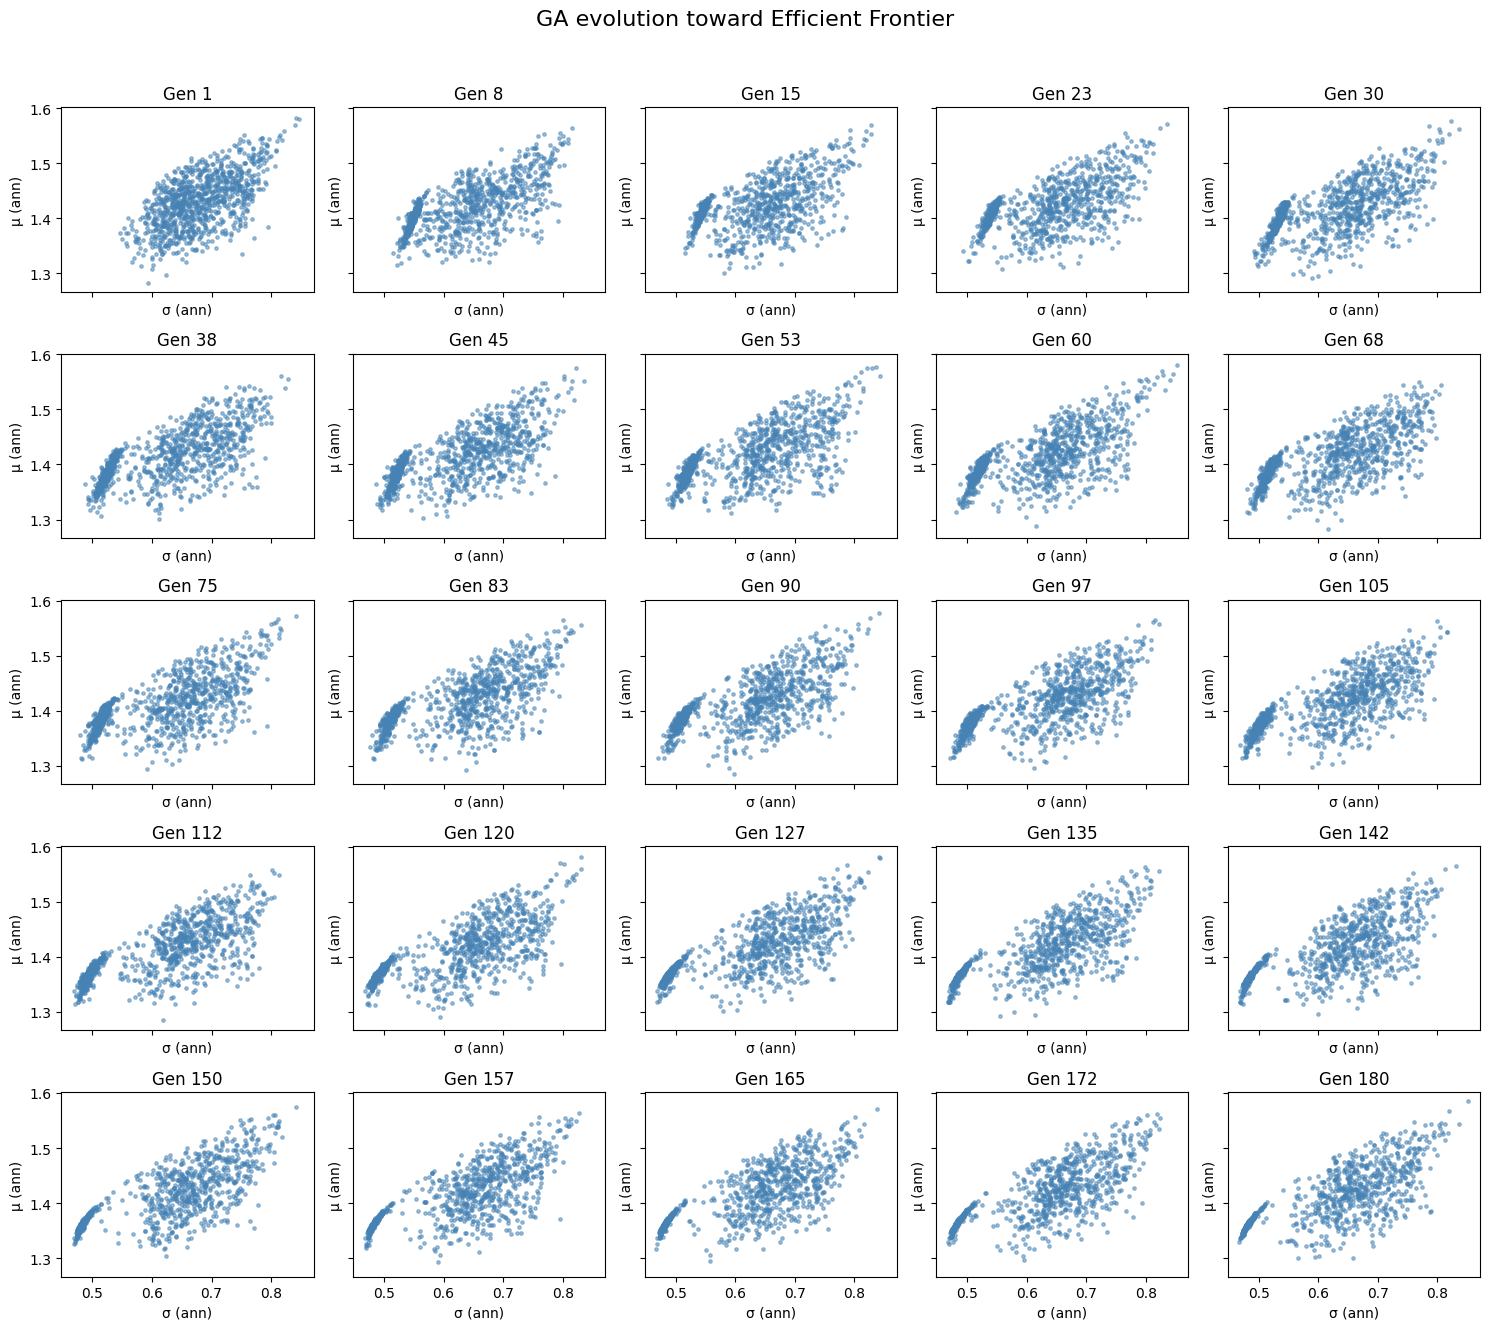

In [9]:
# --------------------------------------------------------------
# 6.1) Инициализация на първото поколение
# --------------------------------------------------------------
population = []
while len(population) < POP_SIZE:
    w = np.random.random(len(tickers))
    w /= w.sum()
    if (w > WEIGHT_CAP).any():
        continue
    population.append(w)

# --------------------------------------------------------------
# 6.2) Еволюция и визуализация
# --------------------------------------------------------------
# fig, axs = plt.subplots(PLOT_X, PLOT_Y, figsize=(15, 13), sharex=True, sharey=True)
# axs = axs.flatten()

fig, axs = plt.subplots(PLOT_Y, PLOT_X, figsize=(15, 13),
                        sharex=True, sharey=True)
axs = axs.flatten()
MAX_PLOTS = PLOT_X * PLOT_Y      # 25

# кои поколения ще рисуваме
if NB_GENERATIONS <= MAX_PLOTS:
    gens_to_plot = list(range(NB_GENERATIONS))
else:
    # равномерни индекси, винаги включва 0
    gens_to_plot = (np.linspace(0, NB_GENERATIONS - 1,
                                num=MAX_PLOTS, dtype=int)
                      .tolist())

print("Ще се визуализират поколения:", gens_to_plot)

for g in range(NB_GENERATIONS):
    # ── статистика за текущото поколение ───────────────────────
    res = np.zeros((2, POP_SIZE))            # σ, μ  (годишни)
    for i, w in enumerate(population):
        mu_bar  = w @ means_bar
        sig_bar = np.sqrt(w @ cov_bar @ w)
        res[1, i] = mu_bar  * PERIODS_PER_YEAR
        res[0, i] = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    # ── чертаем само ако g e в списъка ──────────────────────────
    if g in gens_to_plot:
        plot_idx = gens_to_plot.index(g)     # 0 … 24
        ax = axs[plot_idx]
        ax.scatter(res[0], res[1], s=6, alpha=0.5, c='steelblue')
        ax.set_title(f'Gen {g+1}')
        ax.set_xlabel('σ (ann)')
        ax.set_ylabel('μ (ann)')

    # ── еволюираме към следващо поколение ───────────────────────
    population = next_generation(population)

plt.suptitle('GA evolution toward Efficient Frontier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [10]:
TOP_N = 20        # how many best portfolios you want to list

def ann_stats(w: np.ndarray) -> tuple[float, float, float]:
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    sharpe  = (mu_ann - RISK_FREE) / sig_ann
    return mu_ann, sig_ann, sharpe

# 1) take the best TOP_N by Sharpe
best_pop = sorted(population, key=fitness, reverse=True)[:TOP_N]

# 2) build one combined table
records = []
for rank, w in enumerate(best_pop, 1):
    mu, sig, shp = ann_stats(w)
    rec = {
        'Rank'      : rank,
        'Annual μ'  : round(mu, 4),
        'Annual σ'  : round(sig, 4),
        'Sharpe'    : round(shp, 3)
    }
    # add the weights, rounded to 3 dp
    rec.update({tkr: round(w[i], 3) for i, tkr in enumerate(tickers)})
    records.append(rec)

top_df = (pd.DataFrame(records)
            .set_index('Rank')
            .sort_index())

display(top_df)


,Annual μ,Annual σ,Sharpe,BTC,ADA,ALGO,ANKR
Rank,,,,,,,
1,1.3391,0.4693,2.853,0.937,0.006,0.000,0.057
2,1.3374,0.4687,2.853,0.943,0.005,0.000,0.052
3,1.3459,0.4718,2.853,0.917,0.007,0.000,0.076
4,1.3482,0.4729,2.851,0.909,0.008,0.000,0.083
5,1.3479,0.4728,2.851,0.909,0.008,0.002,0.081
6,1.3494,0.4734,2.850,0.905,0.008,0.000,0.086
7,1.3496,0.4735,2.850,0.901,0.000,0.025,0.074
8,1.3495,0.4736,2.850,0.903,0.008,0.003,0.086
9,1.3507,0.4740,2.849,0.901,0.009,0.000,0.090


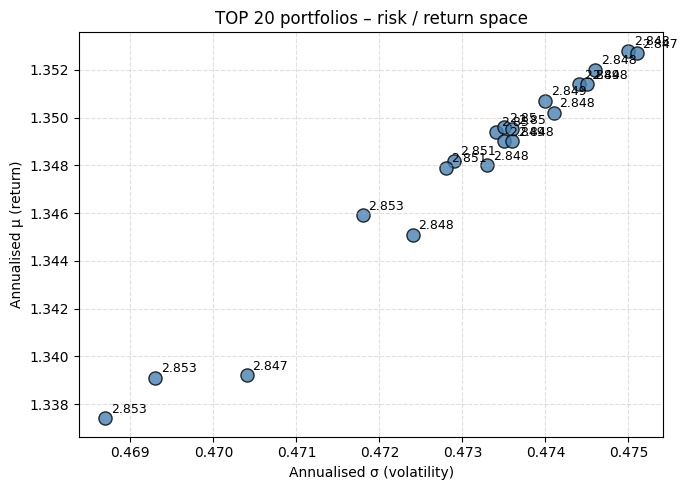

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(top_df['Annual σ'], top_df['Annual μ'],
            s=90, color='steelblue', edgecolors='k', alpha=0.8)

# (по желание) етикет към всяка точка – номерът в класацията
for rank, row in top_df.iterrows():
    plt.annotate(str(row['Sharpe']),
                 (row['Annual σ'], row['Annual μ']),
                 textcoords="offset points",
                 xytext=(4, 4), ha='left', fontsize=9)

plt.xlabel('Annualised σ (volatility)')
plt.ylabel('Annualised μ (return)')
plt.title(f'TOP {len(top_df)} portfolios – risk / return space')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [12]:
best_w = top_df.iloc[0][tickers].to_dict()
best_w

# ПОРТФЕЙЛ С МАКС. SHARPE
#   Год. доходност : 98.79%
#   Год. волатилност : 60.37%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.11	0.09	0.3

# ──────────────────────────────────────────────────────────────────────
# ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
#   Год. доходност : 90.08%
#   Год. волатилност : 57.66%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.31	0.12	0.07

{'BTC': 0.937, 'ADA': 0.006, 'ALGO': 0.0, 'ANKR': 0.057}

In [13]:
# -*- coding: utf-8 -*-
"""
Backtrader static-weight portfolio back-test
"""
import matplotlib
matplotlib.use('Agg')  
import backtrader as bt
import pandas as pd
from pathlib import Path


# ---------- Параметри ------------------------------------------------------

WEIGHTS = best_w

DATA_DIR       = Path('../resources/data/raw')   # коригирай пътя, ако е нужно
STARTING_CASH  = 100_000
COMMISSION     = 0.001        # 0.1 %
REBALANCE_DAYS = 30         # напр. 30 за месечен ребаланс


# ---------- Стратегия ------------------------------------------------------

class StaticWeightStrategy(bt.Strategy):
    """
    Поддържа фиксирани тегла. Ребалансира:
      • веднъж на първата свещ;
      • през `rebalance_days`, ако е зададено.
    """
    params = (
        ('weights',         None),
        ('rebalance_days',  None),
    )

    def __init__(self):
        self.rebalanced_init = False     # ще ребалансираме при първата свещ
        self.last_rebalance  = None      # календарно следене (ако е нужно)

    # --------------------------------------------------
    def next(self):
        dt = self.datas[0].datetime.date(0)   # текуща дата

        # --- първоначален ребаланс ---------------------------------
        if not self.rebalanced_init:
            self.rebalance()
            self.rebalanced_init = True
            self.last_rebalance  = dt
            return                          # излизаме, за да не удвоим ребаланса

        # --- периодичен ребаланс -----------------------------------
        if self.p.rebalance_days:
            if (dt - self.last_rebalance).days >= self.p.rebalance_days:
                self.rebalance()
                self.last_rebalance = dt

    # --------------------------------------------------
    def rebalance(self):
        """
        Изравняване на позициите към зададените тегла.
        """
        port_value = self.broker.getvalue()
        for data in self.datas:
            w = self.p.weights.get(data._name, 0.0)
            self.order_target_percent(data=data, target=w)

    # --------------------------------------------------
    def log(self, txt, dt=None):
        pass  # махни 'pass' и сложи print, ако искаш лог


# ---------- Четене на CSV → DataFeed --------------------------------------

def load_feed(path: str | Path, name: str,
              from_date=None, to_date=None) -> bt.feeds.PandasData:
    df = (pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
            .sort_index()
            .resample('1D')
            .agg({'open':'first', 'high':'max', 'low':'min',
                  'close':'last',  'volume':'sum'})
            .dropna())
    # филтрираме периода
    if from_date is not None:
        df = df.loc[from_date:]
    if to_date is not None:
        df = df.loc[:to_date]

    print(f'{name}: {len(df):>4} дни | {df.index.min().date()} → {df.index.max().date()}')
    return bt.feeds.PandasData(dataname=df, name=name,
                               timeframe=bt.TimeFrame.Days, compression=1)


# ---------- Cerebro pipeline ----------------------------------------------

cerebro = bt.Cerebro()

# 1) стратегия
cerebro.addstrategy(
    StaticWeightStrategy,
    weights=WEIGHTS,
    rebalance_days=REBALANCE_DAYS
)

# 2) брокер
cerebro.broker.setcash(STARTING_CASH)
cerebro.broker.setcommission(commission=COMMISSION)
#  ➜  BUY/SELL стрелки
cerebro.addobserver(bt.observers.BuySell)     # 📈 показва мястото на всеки ордер
cerebro.addobserver(bt.observers.Trades)      # 💬 балони с резултата от сделката

TEST_FROM = test_prices.index.min().date()
TEST_TO   = test_prices.index.max().date()
# 3) данни
cerebro.adddata(load_feed(DATA_DIR / 'BTC_USDT_1m.csv',  'BTC',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'ADA_USDT_1m.csv',  'ADA',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'ALGO_USDT_1m.csv', 'ALGO',from_date=TEST_FROM, to_date=TEST_TO))
cerebro.adddata(load_feed(DATA_DIR / 'ANKR_USDT_1m.csv', 'ANKR',from_date=TEST_FROM, to_date=TEST_TO))

# ---------- Бектест --------------------------------------------------------

print(f'\n🟡  Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}')
cerebro.run()
print(f'🟢  Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
figs = cerebro.plot(iplot=True,                 # True = изкарва директно в cell-а
             style='candlestick',
             volume=False,
             barup='lime', bardown='red')
fig = figs[0][0]                              # първият (и единствен) прозорец
fig.savefig('4_assets_backtest_chart.png', dpi=300)    # => ./backtest_chart.png
print('Графиката е записана в backtest_chart.png')
# cerebro.plot(style='candlestick')   # махни коментара за графика


BTC:   74 дни | 2024-03-27 → 2024-06-08
ADA:   74 дни | 2024-03-27 → 2024-06-08
ALGO:   74 дни | 2024-03-27 → 2024-06-08
ANKR:   74 дни | 2024-03-27 → 2024-06-08

🟡  Starting Portfolio Value: 100,000.00
🟢  Final Portfolio Value:    97,571.11


<IPython.core.display.Javascript object>

Графиката е записана в backtest_chart.png
